## Multi-modal RAG

Many documents contain a mixture of content types, including text and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:`

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis

`Option 2:`

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text
* Pass text chunks to an LLM for answer synthesis

`Option 3`

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

---

This cookbook highlights `Option 3`.

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) to store raw text and images along with their summaries for retrieval.
* We will use GPT-4V for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).

---

A separate cookbook highlights `Option 1` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG_chroma.ipynb).

And option `Option 2` is appropriate for cases when a multi-modal LLM cannot be used for answer synthesis (e.g., cost, etc).

![mulimodal_rag_flowchart.png](mulimodal_rag_flowchart.png)

## Packages

In addition to the below pip packages, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [1]:
# Mount the drive first
#from google.colab import drive
#drive.mount("/content/drive/")

In [2]:
#!pip install virtualenv

In [3]:
#!virtualenv /content/drive/MyDrive/colab_env

In [4]:
#!source /content/drive/MyDrive/colab_env/bin/activate

In [5]:
# Add the path of virtual environment (colab_env) site-packages
# to colaboratory system path
#import sys
#sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.8/site-packages")

In [6]:
#! pip install "unstructured[all-docs]" pillow pydantic lxml matplotlib

In [7]:
#!sudo apt-get update

In [8]:
#!sudo apt-get install poppler-utils

In [9]:
#!sudo apt-get install libleptonica-dev tesseract-ocr libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn

In [10]:
#!sudo apt-get install libleptonica-dev tesseract-ocr libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn

In [11]:
#!pip install unstructured-pytesseract
#!pip install tesseract-ocr

In [12]:
#! pip install -U langchain openai chromadb langchain-experimental
#! pip install -U langchain langchain-google-genai chromadb langchain-experimental

In [13]:
#!pip install wikipedia
#!pip install arxiv
#!pip install langchainhub

In [14]:
#!pip install datasets

## Data Loading

### Partition PDF tables, text, and images
  
Let's look at a [popular blog](https://cloudedjudgement.substack.com/p/clouded-judgement-111023) by Jamin Ball.

This is a great use-case because much of the information is captured in images (of tables or charts).

We use `Unstructured` to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

---

To skip `Unstructured` extraction:

[Here](https://drive.google.com/file/d/1QlhGFIFwEkNEjQGOvV_hQe4bnOLDJwCR/view?usp=sharing) is a zip file with a sub-set of the extracted images and pdf.

If you want to use the provided folder, then simply opt for a [pdf loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf) for the document:

```
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(path + fname)
docs = loader.load()
tables = [] # Ignore w/ basic pdf loader
texts = [d.page_content for d in docs]
```

In [2]:
import os
import base64
import uuid
import re
import io
import requests
import time
from PIL import Image
import matplotlib.pyplot as plt
#from langchain.agents import create_openai_tools_agent, AgentExecutor
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
#from langchain_core.tools import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
#from langchain import hub
from unstructured.partition.pdf import partition_pdf
from langchain.retrievers import MultiVectorRetriever
from langchain_core.stores import InMemoryStore
from langchain_core.documents import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from IPython.display import HTML, display, Markdown
from langsmith import Client
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision
)
#from ragas.llms import LangchainLLMWrapper
#from ragas.embeddings import LangchainEmbeddingsWrapper
import warnings
warnings.filterwarnings("ignore")
from dotenv import load_dotenv
import torch
%matplotlib inline

In [3]:
# Check if CUDA is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
#https://python.langchain.com/v0.2/docs/integrations/chat/google_generative_ai/
# load .env file to environment
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')
os.environ["LANGCHAIN_API_KEY"]=os.getenv('LANGCHAIN_API_KEY')
os.environ["OPENAI_API_KEY"]=os.getenv('OPENAI_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Tracing Multimodal info retrival from PDF"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [5]:
import google.generativeai as genai
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

## List models

Now you're ready to call the Gemini API. Use `list_models` to see the available Gemini models:

* `gemini-1.5-pro`: optimized for high intelligence tasks, the most powerful Gemini model
* `gemini-1.5-flash`: optimized for multi-modal use-cases where speed and cost are important

In [6]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924


## Create the langsmith client to interact with the API

In [7]:
# Initialize the Client with the API key
client = Client(api_key=os.environ["LANGCHAIN_API_KEY"])

In [8]:
#https://python.langchain.com/docs/integrations/text_embedding/google_generative_ai/
google_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [9]:
def load_model(model_name):
  # if model_name=="gemini-pro":
  #   llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
  # else:
  #   llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash")
  llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

  return llm

In [10]:
model_text=load_model("gemini-1.5-flash")
model_text.invoke("Answer with Simple 'Yes' or 'No'. Question: Is mango a Fruit?").content

'Yes. \n'

In [11]:
def get_image(url,filename,extension):
  content = requests.get(url).content
  with open(f'./{filename}.{extension}', 'wb') as f:
    f.write(content)
  image = Image.open(f"./{filename}.{extension}")
  image.show()
  return image

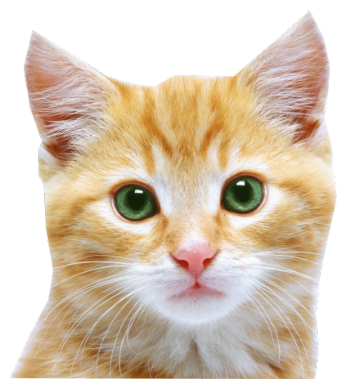

In [12]:
image = get_image("https://www.transparentpng.com/thumb/cat/DTQ8pR-cat-png.png",
                 "cat-image",
                 "png")


plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
# Function to convert an image to a base64-encoded string
def pil_to_base64(img):
    buffered = io.BytesIO() #saving it into an in-memory buffer
    #img.save(buffered, format="JPEG")
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8") #encodes bytes into a Base64 string
    return img_str

#vision_model = load_model("gemini-pro-vision") #deprecated
vision_model = load_model("gemini-1.5-flash")
prompt = "give me summary of this image in 10 words"

# Convert the PIL image to a base64 string
image_base64 = pil_to_base64(image)
#image_data_url = f"data:image/jpeg;base64,{image_base64}"
image_data_url = f"data:image/png;base64,{image_base64}"

message = HumanMessage(
    content=[
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": image_data_url}
    ]
)

print(vision_model.invoke([message]).content)

** Message: 00:02:57.024: main.vala:507: Starting session with system profile


Cute orange tabby kitten with green eyes. 



In [14]:
llm_vision = load_model("gemini-1.5-flash")
llm_text = load_model("gemini-1.5-flash")



## Define additional helper functions

In [15]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

In [16]:
def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

In [17]:
def is_image_data(b64data):
    """Check if the base64 data is an image by looking at the start of the data"""
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]
        for sig in image_signatures.keys():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

In [18]:
def resize_base64_image(base64_string, size=(128, 128)):
    """Resize an image encoded as a Base64 string"""
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))
    resized_img = img.resize(size, Image.LANCZOS)
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [19]:
def split_image_text_types(docs):
    """Split base64-encoded images and texts"""
    #print("split_image_text_types - docs:", docs)
    #print("length of docs:", len(docs))
    b64_images = []
    texts = []
    for doc in docs:
        # Check if doc is a Document object and extract its content
        if isinstance(doc, Document):
            doc = doc.page_content
            #print("It is a Document object and it's content: ", doc)

        # Check if the document is an image (base64 encoded)
        if looks_like_base64(doc) and is_image_data(doc):
            #print("It is an image (base64 encoded) and 1st 8 encoded characters:",doc[:8])
            # Resize the image and append it to the b64_images list
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        elif isinstance(doc, str):
            #print("It is a text string")
            texts.append(doc)
        else:
            raise ValueError("Unsupported document type")
    
    #print("split_image_text_types - b64_images:", b64_images)  # Debugging line
    #print("split_image_text_types - texts:", texts)  # Debugging line
    
    #Return a dictionary with 'images' and 'texts' keys
    #if len(b64_images) > 0:
        #return {"images": b64_images[:1], "texts": []}
    return {"images": b64_images, "texts": texts}

In [20]:
def img_prompt_func(data_dict):
    """Join the context into a single string"""
    #print(data_dict)
    #print(data_dict["context"].keys())
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are a helpful assistant.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide relevant information to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
            #"Don't answer if you are not sure and decline to answer and say 'Sorry, I don't have much information about it.'"
            #"Just return the helpful answer in as much as detailed possible."
        ),
    }
    messages.append(text_message)
    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    return [HumanMessage(content=messages)]

## Define the PDF processing function

In [21]:
# split the file to text, table and images
def doc_partition(in_path,out_path,file_name):
  full_path = os.path.join(in_path, file_name)

  # Partition the PDF document
  raw_pdf_elements = partition_pdf(
    #filename="/content/data/2005.11401v4.pdf",
    #filename=in_path + file_name,
    filename=full_path,
    strategy="hi_res",
    extract_images_in_pdf=True,
    #infer_table_structure=True,
    #chunking_strategy="by_title",
    extract_image_block_types=["Image", "Table"],
    extract_image_block_to_payload=False,
    #extract_image_block_output_dir="extracted_data"
    extract_image_block_output_dir=out_path
    )
  return raw_pdf_elements

#input_path = "/content/sample_data/"
#output_path = "/content/extracted_data/"

input_path = "./data/"
output_path = "./extracted_data/"
#file_name = "2005.11401v4.pdf"
file_name = "1706.03762v7.pdf"
raw_pdf_elements = doc_partition(input_path,output_path,file_name)

In [22]:
#import shutil
#shutil.rmtree('/content/drive/MyDrive/extracted_data/')
#shutil.rmtree('/content/drive/MyDrive/mm_rag_vectorstore.db')

In [23]:
raw_pdf_elements

In [24]:
Header = []
Footer = []
Title = []
NarrativeText = []
Text = []
ListItem = []
Table = []
ImageElement = []
CompositeElement = []

for element in raw_pdf_elements:
    if "unstructured.documents.elements.Header" in str(type(element)):
        Header.append(str(element))
    elif "unstructured.documents.elements.Footer" in str(type(element)):
        Footer.append(str(element))
    elif "unstructured.documents.elements.Title" in str(type(element)):
        Title.append(str(element))
    elif "unstructured.documents.elements.NarrativeText" in str(type(element)):
        NarrativeText.append(str(element))
    elif "unstructured.documents.elements.Text" in str(type(element)):
        Text.append(str(element))
    elif "unstructured.documents.elements.ListItem" in str(type(element)):
        ListItem.append(str(element))
    elif "unstructured.documents.elements.Table" in str(type(element)):
        Table.append(str(element))
    elif "unstructured.documents.elements.Image" in str(type(element)):
        ImageElement.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        CompositeElement.append(str(element))

In [25]:
ImageElement[0]

'Output Probabilities Add & Norm Feed Forward Add & Norm Multi-Head Attention a, Add & Norm Add & Norm Feed Forward Nx | Cag Norm) Add & Norm Masked Multi-Head Multi-Head Attention Attention ae a, Lt Positional Positional Encoding CY © @ Encoding Input Output Embedding Embedding Inputs Outputs (shifted right)'

In [26]:
len(ImageElement)

7

In [27]:
Table[2]

'N dmodel dff h dk dv Pdrop ϵls train steps PPL (dev) BLEU params (dev) ×106 base 6 512 2048 8 64 64 0.1 0.1 100K 4.92 25.8 65 1 512 512 5.29 24.9 (A) 4 16 128 32 128 32 5.00 4.91 25.5 25.8 32 16 16 5.01 25.4 (B) 16 32 5.16 5.01 25.1 25.4 58 60 2 6.11 23.7 36 4 5.19 25.3 50 8 4.88 25.5 80 (C) 256 32 32 5.75 24.5 28 1024 128 128 4.66 26.0 168 1024 5.12 25.4 53 4096 4.75 26.2 90 0.0 5.77 24.6 (D) 0.2 0.0 4.95 4.67 25.5 25.3 0.2 5.47 25.7 (E) positional embedding instead of sinusoids 4.92 25.7'

In [28]:
len(Table)

4

In [29]:
NarrativeText[5]

'Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu'

In [30]:
len(NarrativeText)

83

In [31]:
Text[2]

'2'

In [32]:
len(Text)

18

In [33]:
ListItem[2]

'• Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to illegal connections. See Figure 2.'

In [34]:
len(ListItem)

43

In [35]:
# Define the summary chain for tables
prompt_table = """You are an assistant tasked with summarizing tables for retrieval. \
These summaries will be embedded and used to retrieve the raw table elements. \
Give a concise summary of the table that is well optimized for retrieval. Table:{element}"""
prompt = ChatPromptTemplate.from_template(prompt_table)
#model = ChatOpenAI(temperature=0, model="gpt-4", max_tokens=1024)
#model = ChatGoogleGenerativeAI(temperature=0, model=llm_text, max_tokens=1024)
model = ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-flash", max_tokens=1024, device=device)

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()
table_summaries = summarize_chain.batch(Table, {"max_concurrency": len(Table)})

In [36]:
table_summaries[3]

'This table presents F1 scores for different parser training methods on the WSJ dataset. The methods include discriminative, semi-supervised, generative, and multi-task training. The highest F1 score is achieved by Dyer et al. (2016) using a generative approach, reaching 93.3. \n'

In [37]:
# Define the summary chain for text
prompt_text = """You are an assistant tasked with summarizing text for retrieval. \
These summaries will be embedded and used to retrieve the raw text elements. \
Give a concise summary of the text that is well optimized for retrieval. NarrativeText: {element}"""
prompt = ChatPromptTemplate.from_template(prompt_text)
#model = ChatOpenAI(temperature=0, model="gpt-4")
model = ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-flash", max_tokens=1024, device=device)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()
#text_summaries = summarize_chain.batch(NarrativeText, {"max_concurrency": len(NarrativeText)})

In [38]:
# Function to process elements in batches with delay
def process_in_batches(elements, batch_size=5, delay=15):
    summaries = []
    for i in range(0, len(elements), batch_size):
        batch = elements[i:i + batch_size]
        try:
            batch_summaries = summarize_chain.batch(batch, {"max_concurrency": len(batch)})
            summaries.extend(batch_summaries)
        except Exception as e:
            print(f"Error processing batch {i//batch_size + 1}: {e}")
        time.sleep(delay)
    return summaries

In [39]:
# Process NarrativeText in batches
text_summaries = process_in_batches(NarrativeText, batch_size=5, delay=50)

In [40]:
text_summaries[3]

'This text appears to be a simple identifier for Google Research, likely used in email addresses or other internal systems. It does not contain any meaningful content for retrieval. \n'

In [41]:
# Define functions for image processing
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def image_summarize(img_base64, prompt):
    #chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)
    chat = ChatGoogleGenerativeAI(model="gemini-1.5-flash", max_tokens=1024, device=device)
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
                ]
            )
        ]
    )
    return msg.content


In [42]:
def generate_img_summaries(path):
    img_base64_list = []
    image_summaries = []
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))
    return img_base64_list, image_summaries

#fpath="/content/extracted_data/"
fpath="./extracted_data/"

img_base64_list, image_summaries = generate_img_summaries(fpath)

In [43]:
img_base64_list[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATEBBYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAo


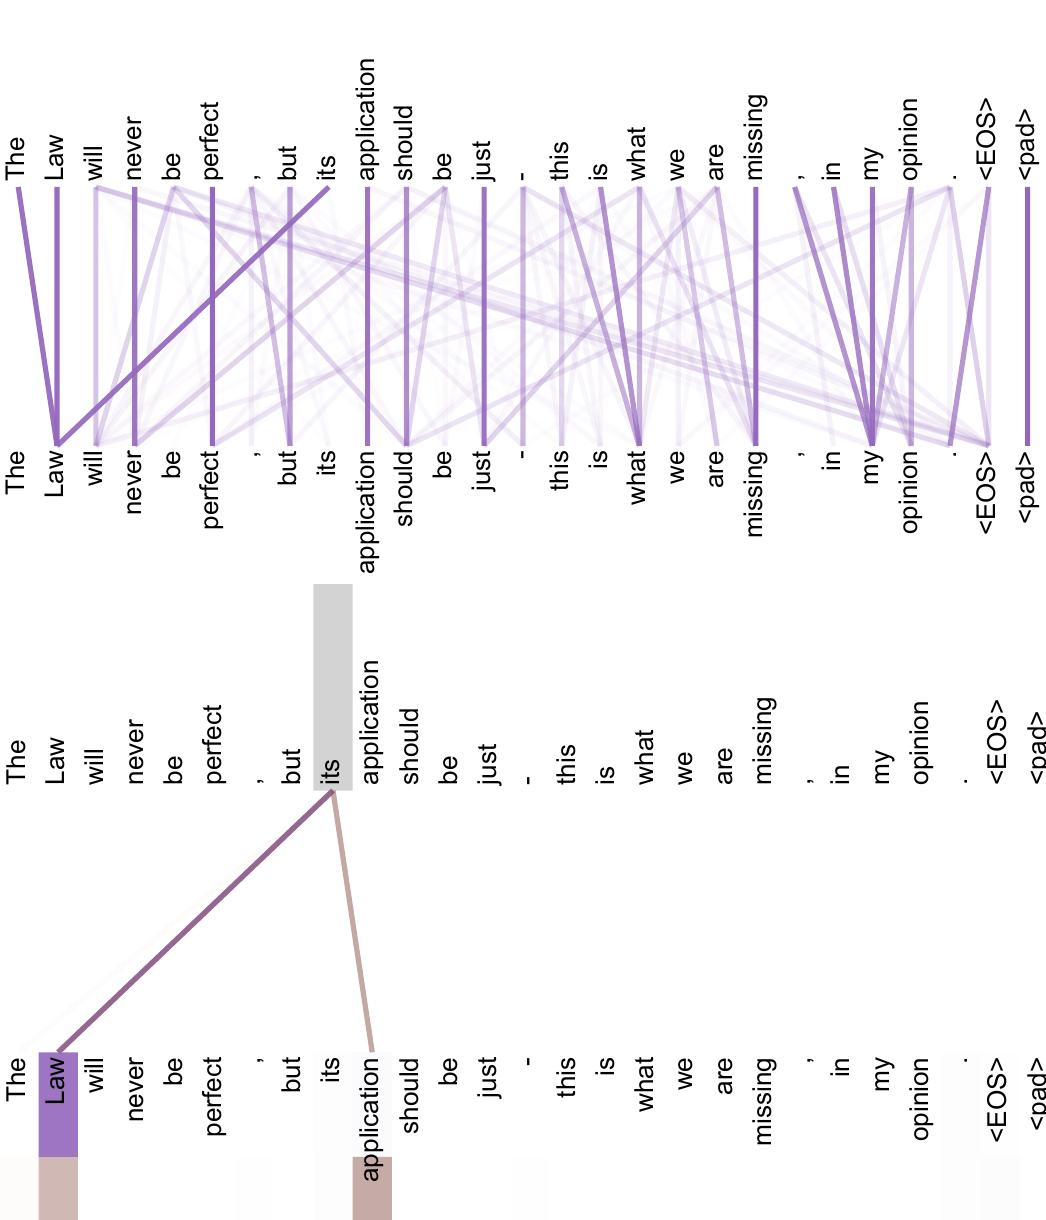

In [44]:
plt_img_base64(img_base64_list[1])

In [45]:
image_summaries[1]

'Alignment of words in two sentences with attention weights.  The word "its" in the first sentence is aligned with the word "application" in the second sentence, and the word "application" in the first sentence is aligned with the word "its" in the second sentence.  The other words are aligned with the same words in the other sentence.'

In [46]:
# Define the file path for the vectorstore database
vectorstore_db_path = os.path.abspath("mm_rag_vectorstore_db")

In [47]:
# Remove old directory if it exists
if os.path.exists(vectorstore_db_path):
    print(f"Removing existing directory: {vectorstore_db_path}")
    os.system(f"rm -rf {vectorstore_db_path}")

In [48]:
# print("Current Working Directory:", os.getcwd())
# os.makedirs(vectorstore_db_path, exist_ok=True)
# print(f"Created directory: {vectorstore_db_path}")

In [49]:
# Try to create the vectorstore
#vectorstore = Chroma(collection_name="mm_rag", embedding_function=OpenAIEmbeddings())
try:
    vectorstore = Chroma(
        collection_name="mm_rag",
        embedding_function=google_embeddings,
        persist_directory=vectorstore_db_path
    )
    # Persist the vectorstore to the specified path
    vectorstore.persist()  # This saves the SQLite database
    print("Database created successfully.")
except Exception as e:
    print(f"Error creating database: {e}")

Database created successfully.


In [50]:
# Load the vectorstore later
try:
    loaded_vectorstore = Chroma(
        collection_name="mm_rag",
        embedding_function=google_embeddings,
        persist_directory=vectorstore_db_path
    )
    print("Database loaded successfully.")
except Exception as e:
    print(f"Error loading database: {e}")

Database loaded successfully.


In [51]:
# Create the multi-vector retriever
#def create_multi_vector_retriever(vectorstore, text_summaries, texts, listitem_summaries, listitem, title_summaries, title, table_summaries, tables, image_summaries, images):
def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images):
    store = InMemoryStore()
    id_key = "doc_id"
    retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=store, id_key=id_key)

    def add_documents(retriever, doc_summaries, original_doc_contents, content_type):
        doc_ids = [str(uuid.uuid4()) for _ in original_doc_contents]
        summary_docs = [
            Document(
                page_content=s,
                metadata={
                    id_key: doc_ids[i],
                    "type": content_type,
                    "original_content": original_doc_contents[i]
                }
            )
            for i, s in enumerate(doc_summaries)
        ]
        #summary_docs = [Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(doc_summaries)]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, original_doc_contents)))

    if text_summaries:
        add_documents(retriever, text_summaries, texts, "text")
    '''if listitem_summaries:
        add_documents(retriever, listitem_summaries, listitem, "list")
    if title_summaries:
        add_documents(retriever, title_summaries, title, "title")'''
    if table_summaries:
        add_documents(retriever, table_summaries, tables, "table")
    if image_summaries:
        add_documents(retriever, image_summaries, images, "image")

    return retriever

In [52]:
# Create and save the retriever
try:
    retriever_multi_vector_img = create_multi_vector_retriever(
        loaded_vectorstore,
        text_summaries,
        NarrativeText,
        table_summaries,
        Table,
        image_summaries,
        img_base64_list
    )
    print("Multi-vector retriever created successfully.")
except Exception as e:
    print(f"Error creating multi-vector retriever: {e}")

Multi-vector retriever created successfully.


In [53]:
#from PIL import Image
# Define the multi-modal RAG chain
def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""
    model = ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-flash", max_tokens=1024, device=device)
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )
    return chain

# Combine everything into a single chain
chain = multi_modal_rag_chain(retriever_multi_vector_img)

## Check retrieval

In [54]:
retriever_multi_vector_img

MultiVectorRetriever(vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7b526a53f190>, docstore=<langchain_core.stores.InMemoryStore object at 0x7b526971fc10>, search_kwargs={})

In [55]:
#query = "Is FEVER a retrieval problem coupled with an challenging entailment reasoning task?"
query = "Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence"
docs = retriever_multi_vector_img.invoke(query)
print("no of docs: ",len(docs))
docs[0]


no of docs:  4


'Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations [4, 27, 28, 22].'

In [56]:
query = "Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence"
docs = retriever_multi_vector_img.get_relevant_documents(query)
print("no of docs: ",len(docs))
docs[0]

no of docs:  4


'Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations [4, 27, 28, 22].'

In [57]:
query = "each of the layers in our encoder and decoder contains a fully\
connected feed-forward network, which is applied to each position separately and identically"
docs = loaded_vectorstore.similarity_search(query)
print("no of docs: ",len(docs))
docs[0]

no of docs:  4


Document(metadata={'doc_id': '307381a0-45e0-4cea-8883-e01a989cc494', 'original_content': 'In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.', 'type': 'text'}, page_content='The encoder and decoder layers in the model use a fully connected feed-forward network, applied independently to each position. This network consists of two linear transformations with a ReLU activation in between. \n')

In [58]:
#query = "Prior work has shown that retrieval improves performance across a variety"
query = "each of the layers in our encoder and decoder contains a fully\
connected feed-forward network, which is applied to each position separately and identically"
docs = retriever_multi_vector_img.invoke(query)
print("no of docs: ",len(docs))
docs[0]

no of docs:  4


'In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.'

In [59]:
#query = "Which sentence between Sentence A and Sentence B is very true?"
query = "Scaled Dot-Product Attention"
docs = retriever_multi_vector_img.invoke(query)
print("no of docs: ",len(docs))
docs[1]

no of docs:  4


'Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.'

In [60]:
docs

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0KHxFq3ifxxrmhaVqMGmW2iiJZHMAlluJHBJwGOFRcY6ZOeorS8O3/iQeKdV0nxA1nJFDbwy2U9rEYxKpZw5YFjhuFBGcDt1rnfGfw4vr7XT4v8F6t/Z2v7cSLn91c4GMHqAcAA5BBwM461N4F+JFxrI1XS/EenGw8QaPE0

In [61]:
#plt_img_base64(docs[1])

In [62]:
#query = "Explain RAG Sequence Model."
#query = "Which sentence between Sentence A and Sentence B is very true?"
query = "How do we compute Attention(Q, K, V )"
chain.invoke(query)

'The attention function is computed as a weighted sum of the values, where the weights are determined by the compatibility of the query with the corresponding keys. The most common attention function is the dot-product attention, which is computed by taking the dot product of the query and each key, scaling the result by the square root of the dimension of the key, and then applying a softmax function to obtain the weights. The weighted sum of the values is then computed using these weights. \nThe image shows the process of computing the scaled dot-product attention. The query, key, and value are first passed through linear layers. The dot product of the query and each key is then computed, and the result is scaled by the square root of the dimension of the key. The softmax function is then applied to obtain the weights. Finally, the weighted sum of the values is computed using these weights.'

In [63]:
query = "Summarize the paper."
chain.invoke(query)

'This paper explores the use of self-attention layers in sequence transduction models, comparing them to recurrent and convolutional layers. The authors argue that self-attention layers offer several advantages, including the ability to capture long-range dependencies and the potential for parallelization. They present experimental results on the WMT 2014 English-to-German translation task, showing that self-attention models achieve state-of-the-art performance. The paper also discusses the implementation details of the self-attention model, including the use of dropout, attention, and residual connections. \n'

# RAG

In [64]:
query_str = "Explain Multi-Head Attention."

# Run the RAG chain
response = chain.invoke(query_str)
print("Response:", response)

Response: Multi-head attention is a mechanism that allows the model to attend to information from different representation subspaces at different positions. It is composed of multiple attention heads that run in parallel. Each attention head computes a different weighted sum of the input values, and the results are concatenated and linearly transformed to produce the final output. This allows the model to capture more complex relationships between the input values than a single attention head could. 

The image shows that multi-head attention is composed of multiple scaled dot-product attention layers. Each layer takes in a query (Q), key (K), and value (V) and outputs a weighted sum of the values. The weights are determined by the similarity between the query and the keys. The outputs of the multiple attention heads are then concatenated and linearly transformed to produce the final output.

The advantage of multi-head attention is that it allows the model to attend to information fro

In [65]:
docs = retriever_multi_vector_img.get_relevant_documents(query_str)
docs

['Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.',
 'The Transformer uses multi-head attention in three different ways:',
 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUl

In [66]:
query_str = "Explain Multi-Head Attention."
docs = loaded_vectorstore.similarity_search(query_str)
docs

[Document(metadata={'doc_id': '3220d5b3-e73f-4240-b3ac-7acb33b9b35f', 'original_content': 'Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.', 'type': 'text'}, page_content='Multi-head attention enables models to attend to information from multiple representation subspaces simultaneously, unlike single-head attention where averaging limits this capability. \n'),
 Document(metadata={'doc_id': '5500ad6b-640a-4cd1-913e-172773f4f130', 'original_content': 'The Transformer uses multi-head attention in three different ways:', 'type': 'text'}, page_content='The Transformer architecture employs multi-head attention in three distinct ways. \n'),
 Document(metadata={'doc_id': '2a609fc4-6cb4-4e4b-8a0a-15ab5d28bb59', 'original_content': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDA

In [67]:
#import shutil
#shutil.rmtree('./extracted_data/')
#shutil.rmtree('./mm_rag_vectorstore_db')

In [68]:
def answer(question):
    relevant_docs = loaded_vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = chain.invoke( question)
    return result, relevant_images

In [69]:
query_str= "What is Scaled Dot-Product Attention?"
result, relevant_images = answer(query_str)

In [70]:
print(result)

Scaled Dot-Product Attention is a type of attention mechanism used in deep learning, particularly in natural language processing (NLP) and computer vision. It is a variant of dot-product attention, which calculates the similarity between queries and keys using dot products.

The key difference between Scaled Dot-Product Attention and regular dot-product attention is the scaling factor of 1/√dk, where dk is the dimension of the keys. This scaling helps to prevent the dot products from becoming too large, which can lead to instability in the softmax function.

The Scaled Dot-Product Attention mechanism involves the following steps:

1. **Compute dot products:** The dot products of the queries and keys are calculated.
2. **Scale dot products:** The dot products are scaled by 1/√dk.
3. **Apply softmax:** The softmax function is applied to the scaled dot products to obtain the attention weights.
4. **Multiply with values:** The attention weights are multiplied with the values to obtain the 

In [71]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0KHxFq3ifxxrmhaVqMGmW2iiJZHMAlluJHBJwGOFRcY6ZOeorS8O3/iQeKdV0nxA1nJFDbwy2U9rEYxKpZw5YFjhuFBGcDt1rnfGfw4vr7XT4v8F6t/Z2v7cSLn91c4GMHqAcAA5BBwM461N4F+JFxrI1XS/EenGw8QaPE0


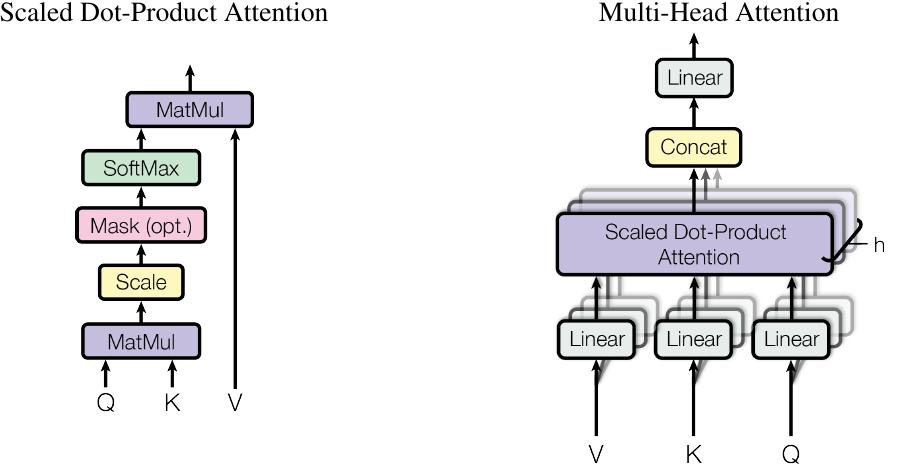

In [72]:
plt_img_base64(relevant_images[0])

### similarity_search_with_relevance_scores ([Visit link](https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.chroma.Chroma.html#langchain_community.vectorstores.chroma.Chroma.similarity_search_with_relevance_scores))
- Return docs and relevance scores in the range [0, 1]


In [73]:
query_str= "Explain Multi-Head Attention."
docs_with_relevance_score=loaded_vectorstore.similarity_search_with_relevance_scores(query_str)

In [74]:
docs_with_relevance_score

[(Document(metadata={'doc_id': '3220d5b3-e73f-4240-b3ac-7acb33b9b35f', 'original_content': 'Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.', 'type': 'text'}, page_content='Multi-head attention enables models to attend to information from multiple representation subspaces simultaneously, unlike single-head attention where averaging limits this capability. \n'),
  0.6666711965847308),
 (Document(metadata={'doc_id': '5500ad6b-640a-4cd1-913e-172773f4f130', 'original_content': 'The Transformer uses multi-head attention in three different ways:', 'type': 'text'}, page_content='The Transformer architecture employs multi-head attention in three distinct ways. \n'),
  0.6614018696359337),
 (Document(metadata={'doc_id': '2a609fc4-6cb4-4e4b-8a0a-15ab5d28bb59', 'original_content': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0a

In [75]:
for doc, score in docs_with_relevance_score:
    print(f"Document: {doc}")
    print(f"Score: {score}")

Document: page_content='Multi-head attention enables models to attend to information from multiple representation subspaces simultaneously, unlike single-head attention where averaging limits this capability. 
' metadata={'doc_id': '3220d5b3-e73f-4240-b3ac-7acb33b9b35f', 'original_content': 'Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.', 'type': 'text'}
Score: 0.6666711965847308
Document: page_content='The Transformer architecture employs multi-head attention in three distinct ways. 
' metadata={'doc_id': '5500ad6b-640a-4cd1-913e-172773f4f130', 'original_content': 'The Transformer uses multi-head attention in three different ways:', 'type': 'text'}
Score: 0.6614018696359337
Document: page_content='Diagram comparing Scaled Dot-Product Attention with Multi-Head Attention. Both use Scaled Dot-Product Attention as a core component. Multi-Head Atte

In [76]:
def answer(question):
    relevant_docs = loaded_vectorstore.similarity_search_with_relevance_scores(question)
    context = ""
    relevant_images = []
    relevant_images_score = []
    for d, score in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
            relevant_images_score.append(score)
    result = chain.invoke( question)
    return result, relevant_images,relevant_images_score

In [77]:
query_str= "What is Multi-Head Attention?"
result, relevant_images,relevant_images_score = answer(query_str)
print(result)

Multi-Head Attention is a mechanism that allows the model to attend to information from different representation subspaces at different positions. It consists of multiple attention heads that run in parallel. Each head performs a scaled dot-product attention operation, and the results are concatenated and then transformed by a linear layer. This allows the model to capture more complex relationships between the input elements. 
The image shows that Multi-Head Attention is composed of multiple Scaled Dot-Product Attention layers running in parallel. Each head performs a scaled dot-product attention operation, and the results are concatenated and then transformed by a linear layer. This allows the model to capture more complex relationships between the input elements.



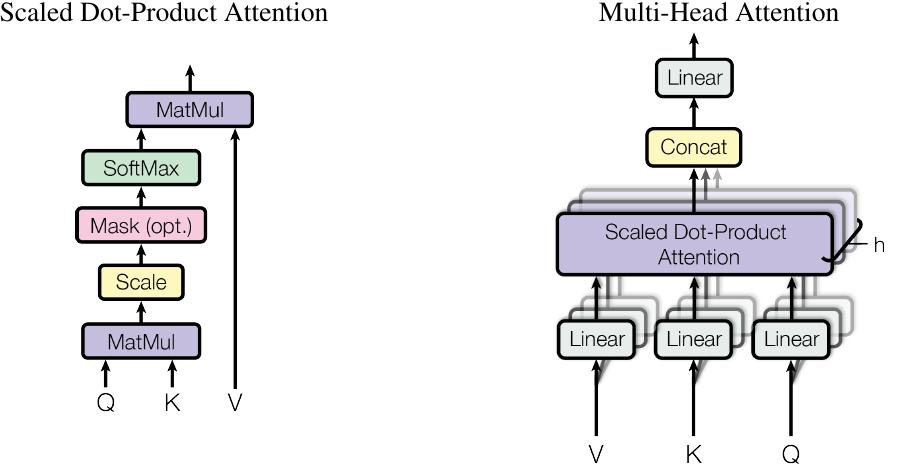

In [78]:
plt_img_base64(relevant_images[0])

In [79]:
relevant_images_score

[0.6858957987085907]

## Evaluating RAG Application with RAGAs

In [117]:
questions = [
    "What is the main architecture proposed in the 'Attention Is All You Need' paper?",
    "How does the self-attention mechanism function in the Transformer model?",
    "What are the advantages of using multi-head attention in the Transformer architecture?",
    "What datasets were used to evaluate the Transformer model?",
    "What results did the Transformer model achieve compared to previous sequence-to-sequence models?"
]

ground_truths = [
    "The main architecture proposed is the Transformer model, which relies entirely on attention mechanisms and does not use recurrence or convolution.",
    "The self-attention mechanism allows the model to weigh the importance of different words in the input sequence relative to each other, enabling the capture of contextual relationships.",
    "Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions, enhancing its ability to learn diverse features.",
    "The Transformer model was evaluated on benchmarks like the WMT 2014 English-to-German and English-to-French translation tasks.",
    "The Transformer model achieved state-of-the-art results in translation tasks, significantly outperforming previous models like LSTMs and GRUs in terms of BLEU scores."
]

answers = []
contexts = []

In [118]:
# Inference
for query in questions:
    result, relevant_images, relevant_images_score = answer(query)
    answers.append(result)
    #relevant_docs = retriever_multi_vector_img.get_relevant_documents(query)
    relevant_docs=loaded_vectorstore.similarity_search_with_relevance_scores(query)
    contexts.append([doc.page_content for doc, score in relevant_docs])

In [119]:
# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)
dataset_df=dataset.to_pandas()
dataset_df

,question,answer,contexts,ground_truth
0,What is the main architecture proposed in the ...,The main architecture proposed in the 'Attenti...,[The Transformer architecture uses stacked sel...,The main architecture proposed is the Transfor...
1,How does the self-attention mechanism function...,The Transformer model utilizes a self-attentio...,[The Transformer is a novel transduction model...,The self-attention mechanism allows the model ...
2,What are the advantages of using multi-head at...,The provided text focuses on the implementatio...,[The Transformer architecture employs multi-he...,Multi-head attention allows the model to joint...
3,What datasets were used to evaluate the Transf...,The provided text states that the Transformer ...,[This table presents variations on the Transfo...,The Transformer model was evaluated on benchma...
4,What results did the Transformer model achieve...,The Transformer model achieved superior result...,"[This paper introduces the Transformer, a nove...",The Transformer model achieved state-of-the-ar...


In [120]:
dataset["contexts"]

[['The Transformer architecture uses stacked self-attention and fully connected layers for both encoding and decoding, as illustrated in Figure 1. \n',
  'The Transformer architecture employs multi-head attention in three distinct ways. \n',
  'This text discusses two common attention functions: additive and dot-product attention. Dot-product attention is similar to the algorithm described in the text, but uses a scaling factor. Additive attention uses a feed-forward network for compatibility function calculation. While theoretically similar, dot-product attention is faster and more space-efficient due to its implementation using optimized matrix multiplication. \n',
  'Self-attention is an attention mechanism that relates different parts of a single sequence to create a representation of the entire sequence. It has been successfully applied to tasks like reading comprehension, summarization, textual entailment, and learning general sentence representations. \n'],
 ['The Transformer is

In [121]:
dataset["ground_truth"]

['The main architecture proposed is the Transformer model, which relies entirely on attention mechanisms and does not use recurrence or convolution.',
 'The self-attention mechanism allows the model to weigh the importance of different words in the input sequence relative to each other, enabling the capture of contextual relationships.',
 'Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions, enhancing its ability to learn diverse features.',
 'The Transformer model was evaluated on benchmarks like the WMT 2014 English-to-German and English-to-French translation tasks.',
 'The Transformer model achieved state-of-the-art results in translation tasks, significantly outperforming previous models like LSTMs and GRUs in terms of BLEU scores.']

In [122]:
dataset["answer"]

["The main architecture proposed in the 'Attention Is All You Need' paper is the **Transformer**. It consists of stacked self-attention and point-wise, fully connected layers for both the encoder and decoder. \n",
 'The Transformer model utilizes a self-attention mechanism to compute representations of its input and output without relying on traditional recurrent neural networks (RNNs) or convolutional layers. This mechanism allows the model to directly attend to all other words in the input sequence, capturing long-range dependencies and relationships between words. \n\nThe self-attention mechanism works by calculating attention weights for each word in the input sequence. These weights represent the importance of each word in relation to the current word being processed. The model then uses these weights to create a weighted sum of the input sequence, effectively focusing on the most relevant words for the current context.\n\nThe Transformer uses multi-head attention, which involves 

In [123]:
for truth in ground_truths:
    for item in truth:
        if not isinstance(item, str):
            raise ValueError("Ground truth elements must be strings")

In [124]:
print(dataset.to_list())

[{'question': "What is the main architecture proposed in the 'Attention Is All You Need' paper?", 'answer': "The main architecture proposed in the 'Attention Is All You Need' paper is the **Transformer**. It consists of stacked self-attention and point-wise, fully connected layers for both the encoder and decoder. \n", 'contexts': ['The Transformer architecture uses stacked self-attention and fully connected layers for both encoding and decoding, as illustrated in Figure 1. \n', 'The Transformer architecture employs multi-head attention in three distinct ways. \n', 'This text discusses two common attention functions: additive and dot-product attention. Dot-product attention is similar to the algorithm described in the text, but uses a scaling factor. Additive attention uses a feed-forward network for compatibility function calculation. While theoretically similar, dot-product attention is faster and more space-efficient due to its implementation using optimized matrix multiplication. \

In [125]:
for context in contexts:
    for item in context:
        if not isinstance(item, str):
            raise ValueError("context elements must be strings")

In [126]:
rag_eval_dataset = Dataset.from_pandas(dataset_df)
rag_eval_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 5
})

In [127]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 5
})

In [128]:
rag_eval_dataset['answer']

["The main architecture proposed in the 'Attention Is All You Need' paper is the **Transformer**. It consists of stacked self-attention and point-wise, fully connected layers for both the encoder and decoder. \n",
 'The Transformer model utilizes a self-attention mechanism to compute representations of its input and output without relying on traditional recurrent neural networks (RNNs) or convolutional layers. This mechanism allows the model to directly attend to all other words in the input sequence, capturing long-range dependencies and relationships between words. \n\nThe self-attention mechanism works by calculating attention weights for each word in the input sequence. These weights represent the importance of each word in relation to the current word being processed. The model then uses these weights to create a weighted sum of the input sequence, effectively focusing on the most relevant words for the current context.\n\nThe Transformer uses multi-head attention, which involves 

In [129]:
rag_eval_dataset.to_list()

[{'question': "What is the main architecture proposed in the 'Attention Is All You Need' paper?",
  'answer': "The main architecture proposed in the 'Attention Is All You Need' paper is the **Transformer**. It consists of stacked self-attention and point-wise, fully connected layers for both the encoder and decoder. \n",
  'contexts': ['The Transformer architecture uses stacked self-attention and fully connected layers for both encoding and decoding, as illustrated in Figure 1. \n',
   'The Transformer architecture employs multi-head attention in three distinct ways. \n',
   'This text discusses two common attention functions: additive and dot-product attention. Dot-product attention is similar to the algorithm described in the text, but uses a scaling factor. Additive attention uses a feed-forward network for compatibility function calculation. While theoretically similar, dot-product attention is faster and more space-efficient due to its implementation using optimized matrix multipl

In [93]:
#llm_text=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [94]:
# evaluation_llm = LangchainLLMWrapper(ChatGoogleGenerativeAI(model="gemini-1.5-flash"))
# evaluation_embedding = LangchainEmbeddingsWrapper(GoogleGenerativeAIEmbeddings(model="models/embedding-001"))

In [130]:
llm=ChatOpenAI(model="gpt-3.5-turbo", api_key = os.environ["OPENAI_API_KEY"], max_tokens=1024, temperature=0)
embedding=OpenAIEmbeddings()

In [131]:
rag_eval_dataset_1= Dataset.from_pandas(dataset_df.iloc[:1])
rag_eval_dataset_1

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 1
})

In [132]:
try:
    result = evaluate(
        dataset=rag_eval_dataset_1,
        metrics=[
            answer_relevancy,
            context_precision,
            faithfulness,
            context_recall
        ],
        llm=llm,
        embeddings=embedding                  
    )
    print(result)
except Exception as e:
    print(f"An error occurred during evaluation: {e}")

Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


{'answer_relevancy': 1.0000, 'context_precision': 1.0000, 'faithfulness': nan, 'context_recall': nan}


In [133]:
result_df = result.to_pandas()
result_df

,question,contexts,reference_contexts,answer,multi_responses,ground_truth,rubric,answer_relevancy,context_precision,faithfulness,context_recall
0,What is the main architecture proposed in the ...,[The Transformer architecture uses stacked sel...,None,The main architecture proposed in the 'Attenti...,None,The main architecture proposed is the Transfor...,None,1.0,1.0,NaN,NaN
